In [1]:
import random
import math
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
# Import necessary modules
import sys
import os

# Add the 'src' directory to the system path if it's not already
sys.path.append(os.path.abspath(os.path.join('environment')))
from environment import BlackjackGame

In [5]:
def save_td_model(q_table, file_path):
    """
    Save the Q-table to a file.

    Args:
        q_table (np.ndarray): The Q-table to save.
        file_path (str): File path to save the Q-table.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    # Save the Q-table
    np.save(file_path, q_table)
    print(f"TD model is saved to {file_path}.")

In [7]:
def load_q_table(file_path):
    """
    Load the Q-table from a file.

    Args:
        file_path (str): File path to load the Q-table from.
    
    Returns:
        np.ndarray: The loaded Q-table.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    # Load and return the Q-table
    q_table = np.load(file_path)
    print(f"TD model is loaded from {file_path}.")
    return q_table

In [75]:
class TemporalDifference:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, lambd=0.9):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd

        # Set up Q-table and eligibility trace
        self.Q = np.zeros((10, 17, 13, 2, 2))  # dealer first card, player hand value, true count index, usable Aces, action 
        self.E = np.zeros((10, 17, 13, 2, 2))


    def map_state(self, state):
        """
        Map a state to the corresponding indices for Q-table and eligibility trace.
        """
        dealer_card, player_total, true_count, usable_ace = state

        # Map dealer card (2–11) to 0–9
        dealer_index = dealer_card - 2
        # Map player hand (4–20) to 0–16
        player_index = player_total - 4
        
        # Bin true count 
        true_count_index = self.map_true_count(true_count)

        # Convert boolean to 0 or 1
        usable_ace_index = int(usable_ace)

        return dealer_index, player_index, true_count_index, usable_ace_index


    def map_true_count(self, true_count):
        if true_count < -5:
            true_count_index = 0
        elif true_count > 5:
            true_count_index = 12
        else:
            # Map true count (-5 to 5) to 1–11
            true_count_index = true_count + 6
        return true_count_index


    def epsilon_greedy_policy(self, state):
        """
        Epsilon-greedy policy for action selection.
        """
        dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
        if random.random() < self.epsilon:
            # Random action
            return random.choice(self.env.actions)
        else:
            return np.argmax(self.Q[dealer_index, player_index, true_count_index, usable_ace_index, :])


    def train(self, num_episodes, on_policy=True, true_count=0):
        """
        Train the agent using Temporal Difference learning with eligibility traces.
        """
        # Reset environment by default
        self.env.reset()
            
        for _ in tqdm(range(num_episodes)):
            # Reset and start a new game
            self.E.fill(0)
            # If true count is specified, reset env using true count before each game
            if true_count:
                self.env.reset(true_count=true_count)
            reward, state, winner = self.env.new_game()

            # Skip games that end immediately
            while winner:
                self.env.reset(true_count=true_count)
                reward, state, winner = self.env.new_game()

            while not winner:
                # Map state
                dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
                
                # Select action using epsilon-greedy policy
                action = self.epsilon_greedy_policy(state)
                reward, next_state, winner = self.env.step(action)

                # Compute target
                if winner:
                    target = reward
                else:
                    next_action = self.epsilon_greedy_policy(next_state)
                    next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index = self.map_state(next_state)

                    if on_policy:
                        target = reward + self.gamma * self.Q[
                            next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index, next_action
                        ]
                    else:
                        target = reward + self.gamma * np.max(
                            self.Q[next_dealer_index, next_player_index, next_true_count_index, next_usable_ace_index, :]
                        )

                # Compute TD error
                delta = target - self.Q[dealer_index, player_index, true_count_index, usable_ace_index, action]

                # Update eligibility trace
                self.E[dealer_index, player_index, true_count_index, usable_ace_index, action] += 1

                # Update Q-values and decay traces
                self.Q += self.alpha * delta * self.E
                self.E *= self.gamma * self.lambd

                # Update state for the next iteration
                state = next_state


    def get_best_action(self, state):
        """
        Returns the best action for a given state based on the trained Q-values.
        """
        dealer_index, player_index, true_count_index, usable_ace_index = self.map_state(state)
        q_values = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, :]

        # Check if the state-action pair has been trained
        if np.all(q_values == 0):
            # Default action is hit if no Q-values are leanrned
            return 1
        else:
            # Return the action with the highest Q-value
            return np.argmax(q_values)
        

    def plot_q_table(self, true_count, usable_aces):
        """
        Plot Q-table heatmaps for the specified true_count and usable_aces (raw values).
        Two heatmaps are displayed: one for action=0 and another for action=1.
    
        Args:
            true_count (int): true count value.
            usable_aces (bool): usable aces value (True/False).
        """
        # Map raw true_count and usable_aces to indices
        true_count_index = self.map_true_count(true_count)
        usable_ace_index = int(usable_aces)
    
        # Determine player hand range and initialize heatmaps
        if usable_aces:
            # Player hand values 12–20
            player_range = range(12, 21)
        else:
            # Player hand values 4–20
            player_range = range(4, 21)

        action_0_data = np.zeros((len(player_range), 10))
        action_1_data = np.zeros((len(player_range), 10))

        # Populate heatmaps
        for dealer_index in range(10):
            for i, player_value in enumerate(player_range):
                # Adjust for Q-table index
                player_index = player_value - 4
                action_0_data[i, dealer_index] = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, 0]
                action_1_data[i, dealer_index] = self.Q[dealer_index, player_index, true_count_index, usable_ace_index, 1]

        # Reverse Q-table
        action_0_data = np.flipud(action_0_data)
        action_1_data = np.flipud(action_1_data)

        # Determine shared color scale
        vmin = math.floor(min(action_0_data.min(), action_1_data.min()))
        vmax = math.ceil(max(action_0_data.max(), action_1_data.max()))

        # Create heatmaps with Seaborn
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        dealer_labels = [str(i) for i in range(2, 12)]
        player_labels = [str(i) for i in reversed(player_range)]
    
        # Action = 0 Heatmap
        sns.heatmap(action_0_data, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0],
                    xticklabels=dealer_labels, yticklabels=player_labels, vmin=vmin, vmax=vmax)
        axes[0].set_title(f"Q-Table Heatmap: Action = Stand\n(True Count = {true_count}, Usable Aces = {usable_aces})")
        axes[0].set_xlabel("Dealer Card")
        axes[0].set_ylabel("Player Hand Total Value")
    
        # Action = 1 Heatmap
        sns.heatmap(action_1_data, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1],
                    xticklabels=dealer_labels, yticklabels=player_labels, vmin=vmin, vmax=vmax)
        axes[1].set_title(f"Q-Table Heatmap: Action = Hit\n(True Count = {true_count}, Usable Aces = {usable_aces})")
        axes[1].set_xlabel("Dealer Card")
        axes[1].set_ylabel("Player Hand Total Value")
    
        # Adjust layout and display
        plt.tight_layout()
        plt.show()


    def plot_policy(self, true_count):
        """
        Plot policy heatmaps for the specified true_count.
        Two heatmaps are displayed: one for usable_aces = False and another for usable_aces = True.
        The plot shows whether to hit (1) or stand (0) based on the Q-values.
    
        Args:
            true_count (int): True count value.
        """
        # Initialize placeholders for policies
        policy_false = []
        policy_true = []
    
        # For usable_aces = False: player hand total is 4–20
        player_range_false = range(4, 21)
        for dealer_index in range(10):
            column_false = []
            for player_total in player_range_false:
                state_false = [dealer_index + 2, player_total, true_count, False]
                action = self.get_best_action(state_false)
                column_false.append(action)
            policy_false.append(column_false)

        # For usable_aces = True: player hand total is 12–20
        player_range_true = range(12, 21)
        for dealer_index in range(10):  # Dealer card: 2–11
            column_true = []
            for player_total in player_range_true:
                state_true = [dealer_index + 2, player_total, true_count, True]
                action = self.get_best_action(state_true)
                column_true.append(action)
            policy_true.append(column_true)
    
        # Convert lists to numpy arrays and flip for proper heatmap orientation
        policy_false = np.flipud(np.array(policy_false).T)
        policy_true = np.flipud(np.array(policy_true).T)

        # Create heatmaps with Seaborn
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        dealer_labels = [str(i) for i in range(2, 12)]
        player_labels_false = [str(i) for i in reversed(player_range_false)]
        player_labels_true = [str(i) for i in reversed(player_range_true)]
    
        # Usable Aces = False Heatmap
        sns.heatmap(policy_false, cmap="coolwarm", cbar=False, annot=False, ax=axes[0],
                    xticklabels=dealer_labels, yticklabels=player_labels_false)
        axes[0].set_title(f"Plot of Policy: True Count = {true_count}\n(Usable Aces = False)")
        axes[0].set_xlabel("Dealer Card")
        axes[0].set_ylabel("Player Hand Total Value")
    
        # Replace annotations with "H" and "S"
        for i in range(policy_false.shape[0]):
            for j in range(policy_false.shape[1]):
                text = "H" if policy_false[i, j] == 1 else "S"
                axes[0].text(j + 0.5, i + 0.5, text, color="black",
                             ha="center", va="center", fontsize=10)
    
        # Usable Aces = True Heatmap
        sns.heatmap(policy_true, cmap="coolwarm", cbar=False, annot=False, ax=axes[1],
                    xticklabels=dealer_labels, yticklabels=player_labels_true)
        axes[1].set_title(f"Plot of Policy: True Count = {true_count}\n(Usable Aces = True)")
        axes[1].set_xlabel("Dealer Card")
        axes[1].set_ylabel("Player Hand Total Value")
    
        # Replace annotations with "H" and "S"
        for i in range(policy_true.shape[0]):
            for j in range(policy_true.shape[1]):
                text = "H" if policy_true[i, j] == 1 else "S"
                axes[1].text(j + 0.5, i + 0.5, text, color="black",
                             ha="center", va="center", fontsize=10)
    
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

In [91]:
# Create environment
env = BlackjackGame()

# Create agent
agent = TemporalDifference(
    env=env,
    alpha=0.1,    # Learning rate
    gamma=0.9,    # Discount factor
    epsilon=0.1,  # Exploration rate
    lambd=1     # Trace decay
)

# Define the number of episodes to train
num_episodes = 2000000

# Train Q-learning agent
agent.train(num_episodes=num_episodes, on_policy=False, true_count=2)

100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [06:19<00:00, 5269.32it/s]


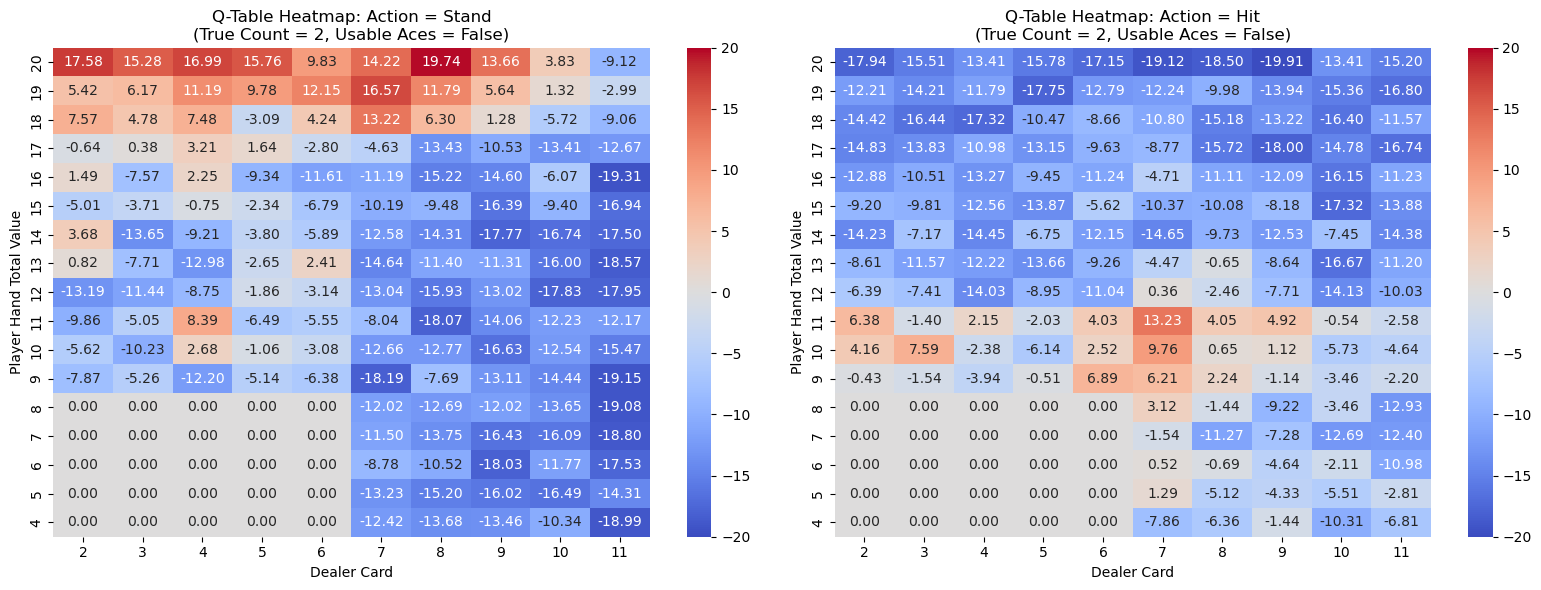

In [93]:
agent.plot_q_table(true_count=2, usable_aces=False)

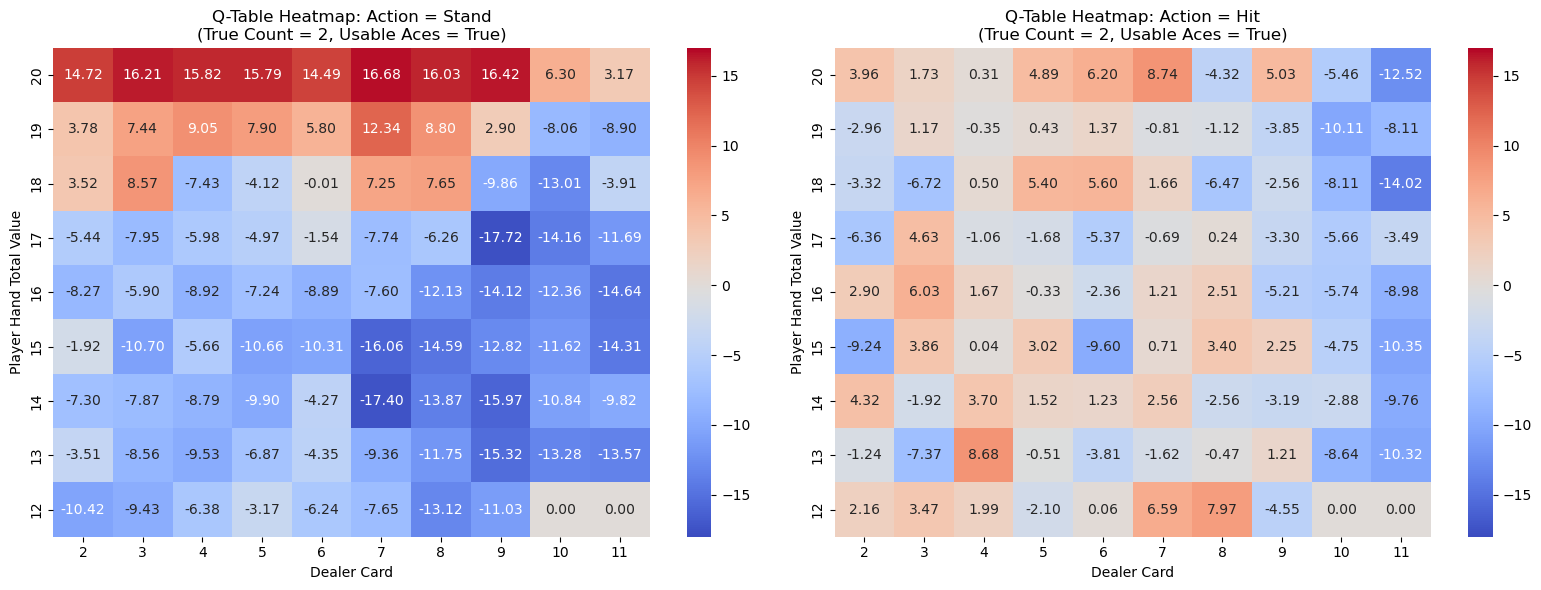

In [95]:
agent.plot_q_table(true_count=2, usable_aces=True)

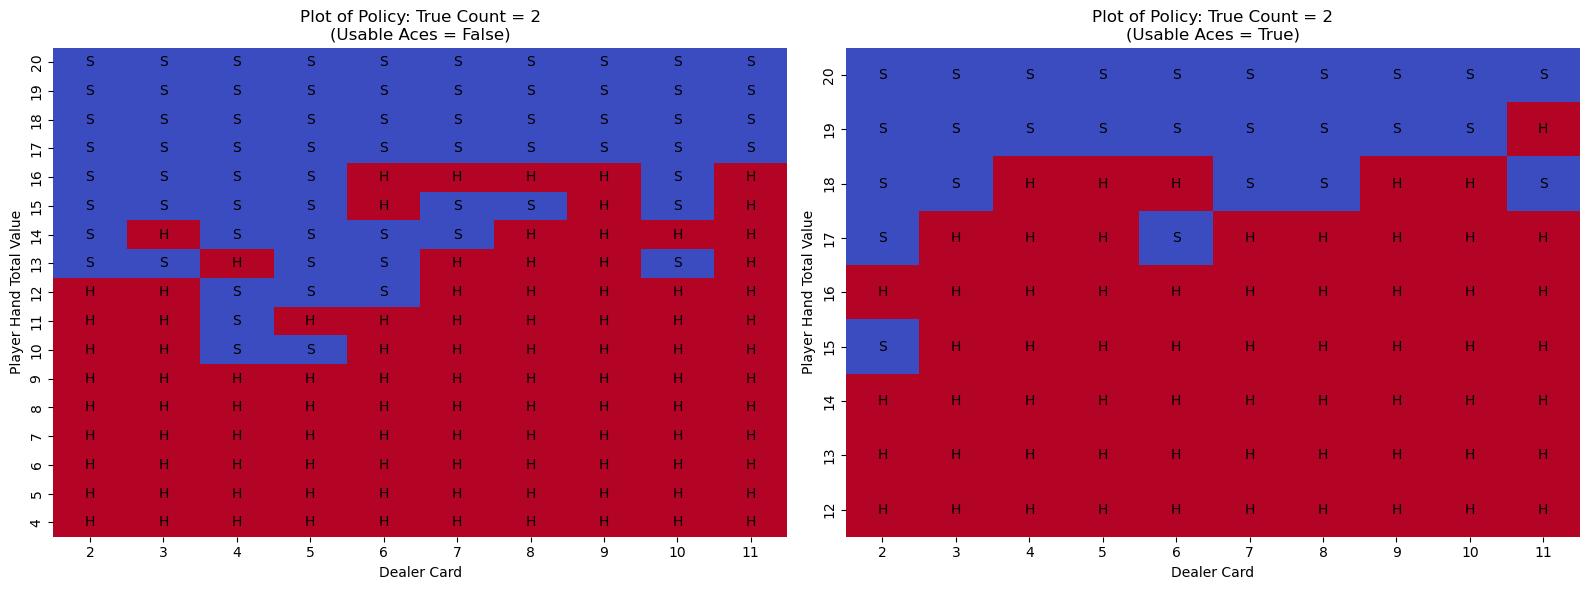

In [97]:
agent.plot_policy(true_count=2)

In [ ]:
num_test_games = 100000
wins = 0
losses = 0
ties = 0
blackjack_count = 0
total_reward = 0
env = BlackjackGame()

for _ in tqdm(range(num_test_games), desc="Testing Games"):
    env.reset(true_count=2)
    game_reward, state, winner = env.new_game()  # Start a new game

    while not winner:
        # Get the best action based on the trained model
        action = agent.get_best_action(state)
        
        # Take the action in the environment
        reward, next_state, winner = env.step(action)
        
        # Accumulate reward for the current game
        game_reward += reward
        
        # Update the state
        state = next_state

    # Track total reward
    total_reward += game_reward

    # Step 3: Record the outcome
    if winner == 'player':
        wins += 1
    elif winner == 'blackjack':
        wins += 1
        blackjack_count += 1
    elif winner == 'dealer':
        losses += 1
    else:  # Tie
        ties += 1

# Compute performance metrics
win_rate = wins / num_test_games
loss_rate = losses / num_test_games
tie_rate = ties / num_test_games
average_reward = total_reward / num_test_games
blackjack_rate = blackjack_count / num_test_games

# Print results
print(f"Results after {num_test_games} test games:")
print(f"Win Rate: {win_rate:.2%}")
print(f"Loss Rate: {loss_rate:.2%}")
print(f"Tie Rate: {tie_rate:.2%}")
print(f"Blackjack Rate: {blackjack_rate:.2%}")
print(f"Total Reward: {total_reward}")
print(f"Average Reward: {average_reward:.2f}")

Testing Games:   5%|██▉                                                        | 5036/100000 [00:00<00:15, 6017.15it/s]

In [16]:
save_td_model(agent.Q, "models/q_learning.npy")

TD model is saved to models/q_learning.npy.
